In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
from tqdm.auto import tqdm
from functools import partial
import utils
#jax.config.update("jax_platform_name", "cpu")
jax.devices()


[cuda(id=0)]

In [2]:
from frozen_lake import FrozenLake

  0%|          | 0/100 [00:00<?, ?it/s]

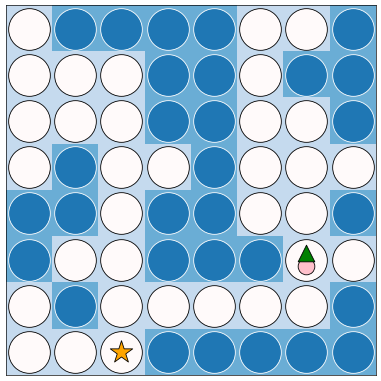

In [7]:
rng_key = jax.random.PRNGKey(42)
env = FrozenLake((8, 8), 0.5)

for i in tqdm(range(100)):
    rng_key, key_init, key_reset = jax.random.split(rng_key, 3)
    env_params = env.init(key_init)
    obs, env_state = env.reset(key_reset, env_params)
utils.render(env_state, env_params)

In [8]:
def rollout(rng_key, steps):
    rng_reset, rng_episode = jax.random.split(rng_key)

    obs, state = env.reset(rng_reset, env_params)

    def policy_step(carry, _):
        """lax.scan compatible step transition in jax env."""
        obs, state, rng = carry
        rng, rng_action, rng_step, rng_reset = jax.random.split(rng, 4)
        action = env.action_space.sample(rng_action)
        next_obs, next_state, reward, done, _ = env.step(rng_step, state, action, env_params)
        obs, state = jax.lax.cond(
            done, lambda: env.reset(rng_reset, env_params), lambda: (next_obs, next_state)
        )
        carry = obs, state, rng
        return carry, (obs, state, action, reward, next_obs, done)

    carry, (obs, state, action, reward, next_obs, done) = jax.lax.scan(
        policy_step, (obs, state, rng_episode), (), steps
    )
    return obs, state, action, reward, next_obs, done

In [9]:
steps = 1000
vectorized_rollout = jax.jit(jax.vmap(partial(rollout, steps=steps)))
rollout = jax.jit(partial(rollout, steps=steps))

(1000, 3, 8, 8)


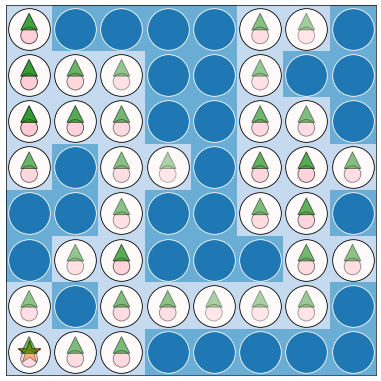

In [10]:
rng_keys = jax.random.split(rng_key, 1)
obs, state, action, reward, next_obs, done = rollout(rng_key)
print(obs.shape)
utils.render(state, env_params)